# Read Dataset


## Factor DF

In [3694]:
import pandas as pd

df = pd.read_csv("feature_data/crisis_data.csv")

df = df.drop(columns=['Unnamed: 0'])

df


,date,ticker,pe_exi,de_ratio,close_price,exp_ret,vol,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,ret_excess
0,2003-03-31,AAP,22.235577,3.196007,13.071248,-0.006888,0.104914,-0.129018,1.09,0.66,-1.94,1.86,-0.78,0.0010,-0.007888
1,2003-04-30,AAP,23.913462,3.196007,14.057592,0.006321,0.118622,0.005435,8.22,1.01,1.15,-4.67,1.07,0.0010,0.005321
2,2003-05-31,AAP,13.396396,3.412518,16.810337,-0.011304,0.083708,-0.159798,6.05,4.82,0.39,-7.01,2.90,0.0009,-0.012204
3,2003-06-30,AAP,13.716216,3.412518,17.211649,0.006985,0.102608,0.029067,1.42,1.66,0.11,0.50,-0.39,0.0010,0.005985
4,2003-07-31,AAP,15.299550,3.412518,19.198484,0.013718,0.100665,0.117226,2.35,4.54,-1.24,-4.14,1.78,0.0007,0.013018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,2009-08-31,XOM,11.299020,1.031506,38.345531,-0.008158,0.048528,-0.105537,3.33,-0.09,7.63,-3.03,3.34,0.0001,-0.008258
11158,2009-09-30,XOM,11.210784,1.031506,38.046097,-0.009114,0.048469,-0.115801,4.08,2.73,1.04,1.31,0.36,0.0001,-0.009214
11159,2009-10-31,XOM,11.710784,1.031506,39.742950,-0.007318,0.048048,-0.096159,-2.59,-4.94,-4.21,4.17,-1.50,0.0000,-0.007318
11160,2009-11-30,XOM,17.663529,1.042706,41.870628,0.000198,0.048568,-0.010755,5.56,-2.68,-0.34,1.00,0.13,0.0000,0.000198


In [3695]:
# split the data into train and test sets
#train_df = df[df['date'] < '2024-01-01']
#test_df = df[df['date'] >= '2024-01-01']

#train_df = df

# Estimate returns & Covariances

In [3696]:
from typing import Dict, List, Tuple
import numpy as np
#import mgarch
factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]


# ----- helper #1 :   β̂  and  F̂  --------------------------------
def fit_beta(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # 1) strip rows that contain any non-finite value
    row_mask = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
    Xc, Yc   = X[row_mask], Y[row_mask]

    beta, *_ = np.linalg.lstsq(Xc, Yc, rcond=None)               # (d_x, d_y)
    resid    = Yc - Xc @ beta                                    # (n, d_y)
    F_hat    = np.diag(resid.var(axis=0, ddof=1))              # (d_y, d_y)
    return beta, F_hat


# ----- helper #2 :   one-step mean & cov ------------------------
def forecast_one_step(x_i, W_i, beta, F_hat):
    y_hat = x_i @ beta                                         # (d_y,)
    V_hat = beta.T @ W_i @ beta + F_hat                        # (d_y, d_y)
    return y_hat, V_hat

# ---- helper #3 : DCC-GARCH forecast of factor covariance ------
#def dcc_garch_cov(X, ndays=1):
    #dist = 't'
    #vol = mgarch.mgarch(dist)
    #vol.fit(X)
    #W_t = vol.predict(ndays)['cov']
    #return W_t

In [3697]:
df['label'] = df.groupby('ticker')['close_price'].shift(-1).gt(df['close_price']).astype(int) * 2 - 1

In [3698]:
df['ret'] = df.groupby('ticker')['close_price'].pct_change().shift(-1).fillna(0)

In [3699]:
df['ret_excess'] = df['ret']

In [3700]:
# get the how many 1s and 0s in the label column
label_counts = df['label'].value_counts()
print("Label counts:")
print(label_counts)

Label counts:
label
 1    6165
-1    4997
Name: count, dtype: int64


In [3701]:
df

,date,ticker,pe_exi,de_ratio,close_price,exp_ret,vol,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,ret_excess,label,ret
0,2003-03-31,AAP,22.235577,3.196007,13.071248,-0.006888,0.104914,-0.129018,1.09,0.66,-1.94,1.86,-0.78,0.0010,0.075459,1,0.075459
1,2003-04-30,AAP,23.913462,3.196007,14.057592,0.006321,0.118622,0.005435,8.22,1.01,1.15,-4.67,1.07,0.0010,0.195819,1,0.195819
2,2003-05-31,AAP,13.396396,3.412518,16.810337,-0.011304,0.083708,-0.159798,6.05,4.82,0.39,-7.01,2.90,0.0009,0.023873,1,0.023873
3,2003-06-30,AAP,13.716216,3.412518,17.211649,0.006985,0.102608,0.029067,1.42,1.66,0.11,0.50,-0.39,0.0010,0.115436,1,0.115436
4,2003-07-31,AAP,15.299550,3.412518,19.198484,0.013718,0.100665,0.117226,2.35,4.54,-1.24,-4.14,1.78,0.0007,0.098925,1,0.098925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,2009-08-31,XOM,11.299020,1.031506,38.345531,-0.008158,0.048528,-0.105537,3.33,-0.09,7.63,-3.03,3.34,0.0001,-0.007809,-1,-0.007809
11158,2009-09-30,XOM,11.210784,1.031506,38.046097,-0.009114,0.048469,-0.115801,4.08,2.73,1.04,1.31,0.36,0.0001,0.044600,1,0.044600
11159,2009-10-31,XOM,11.710784,1.031506,39.742950,-0.007318,0.048048,-0.096159,-2.59,-4.94,-4.21,4.17,-1.50,0.0000,0.053536,1,0.053536
11160,2009-11-30,XOM,17.663529,1.042706,41.870628,0.000198,0.048568,-0.010755,5.56,-2.68,-0.34,1.00,0.13,0.0000,-0.083922,-1,-0.083922


In [3702]:
# -------------------------------------------------------------
# 1.  Build monthly factor (X_df) and asset-return (Y_df) tables

Y_df = (df
        .pivot(index='date', columns='ticker', values='ret_excess') # ret_excess can be used or ret
        .sort_index())

X_df = (df[['date'] + factor_cols]
        .drop_duplicates('date')
        .set_index('date')
        .sort_index())
# create a label_df
label_df = (df
            .pivot(index='date', columns='ticker', values='label')
            .sort_index())

# ------------------------------------------------------------------
# 1.  Find ticker columns with *any* NaNs in Y_df
# ------------------------------------------------------------------
bad_tickers = Y_df.columns[Y_df.isna().any()]

print(f"🗑  Dropping {len(bad_tickers)} tickers with missing returns:")
print(", ".join(map(str, bad_tickers)))

# ------------------------------------------------------------------
# 2.  Drop them from Y_df  (axis=1 ⇒ columns)
# ------------------------------------------------------------------
Y_df = Y_df.drop(columns=bad_tickers)

# ------------------------------------------------------------------
# 3.  OPTIONAL: keep your other pivot tables in sync
#     (uncomment if you have X_df, label_df, etc. with same columns)
# ------------------------------------------------------------------
# X_df      = X_df.drop(columns=bad_tickers, errors="ignore")
label_df  = label_df.drop(columns=bad_tickers, errors="ignore")
# Sigma_fore = Sigma_fore[np.ix_(good_mask, good_mask)]  # inside loop

# ------------------------------------------------------------------
# 4.  Verify — there should be zero NaNs left
# ------------------------------------------------------------------
assert not Y_df.isna().any().any(), "Still NaNs lurking in Y_df!"
print("✅  Y_df is now NaN-free and has", Y_df.shape[1], "tickers.")


🗑  Dropping 47 tickers with missing returns:
AAP, ABG, ACAD, ACIW, ACLS, AEIS, AEO, AGYS, ALG, ALGT, AMN, AMSF, AMZN, ANDE, ARWR, AVA, AWR, AXL, BCPC, BGS, BH, BJRI, BKE, BRK-B, CALM, CCOI, CE, CENX, CNK, COP, COST, CVI, CVX, FCX, FIZZ, FUL, GOOG, HON, JPM, LLY, MA, MGEE, NFLX, NVDA, NWN, V, XOM
✅  Y_df is now NaN-free and has 43 tickers.


In [3703]:
# 1) make sure every index really *is* a DatetimeIndex
X_df.index      = pd.to_datetime(X_df.index)
Y_df.index      = pd.to_datetime(Y_df.index)
label_df.index  = pd.to_datetime(label_df.index)
df['date'] = pd.to_datetime(df['date'])

In [3704]:
# Every row is month-end already ⇒ just iterate over the index
month_ends = X_df.index.sort_values()

lookback = 12          # e.g. use the past 12 months
month_ends = month_ends[lookback:]

In [3705]:
month_ends

DatetimeIndex(['1997-02-28', '1997-03-31', '1997-04-30', '1997-05-31',
               '1997-06-30', '1997-07-31', '1997-08-31', '1997-09-30',
               '1997-10-31', '1997-11-30',
               ...
               '2009-03-31', '2009-04-30', '2009-05-31', '2009-06-30',
               '2009-07-31', '2009-08-31', '2009-09-30', '2009-10-31',
               '2009-11-30', '2009-12-31'],
              dtype='datetime64[ns]', name='date', length=155, freq=None)

In [3706]:
def make_spd(M, eps=1e-6):
    M = (M + M.T) * 0.5  # enforce symmetry
    jitter = eps
    I = np.eye(M.shape[0])
    for _ in range(10):
        try:
            # This will error if M is not SPD
            np.linalg.cholesky(M)
            return M
        except np.linalg.LinAlgError:
            M = M + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

results = []
tickers = Y_df.columns.unique()
for me_date in month_ends:

    # ---------- 1) pick the estimation window ------------
    win_mask  = (X_df.index <= me_date)                     & \
                (X_df.index >  me_date - pd.offsets.MonthEnd(lookback))

    X_window  = X_df.loc[win_mask]
    Y_window  = Y_df.loc[win_mask]

    if len(X_window) < 2:
        continue   # still not enough data – skip

    # ---------- 2)  β̂ , F̂  from the window --------------
    beta_hat, F_hat = fit_beta(X_window.values, Y_window.values)

    # ---------- 3)  Σ̂ (covariance)  ----------------------
    # but most people just use a sample/Exp-Wtd cov here:
    W_hat = np.cov(X_window.values.T, ddof=1)
    #W_hat = dcc_garch_cov(X_window.values)
    
    x_today      = X_df.loc[me_date].values
    mu_fore, Sigma_fore = forecast_one_step(x_today, W_hat, beta_hat, F_hat)
    #  └─ make sure your forecast function is set up for “+1 month”,
    #     not “+1 trading day”.

    W = 12
    R_hist = (Y_df.loc[Y_df.index <= me_date]
                .tail(W)         # 12 rows = 12 months
                .T.values)       # (n_assets × W)
               
    # 5) features ----------------------------------------
    feature_list = ['exp_ret', 'vol','mom', 'pe_exi', 'de_ratio', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

    monthly = (df
               .set_index(['date','ticker'])
               .loc[me_date]
               .reindex(tickers))
    X_feat = monthly[feature_list].values

    # Standardize X_feat now
    mean = X_feat.mean(axis=0, keepdims=True)
    std = X_feat.std(axis=0, keepdims=True) + 1e-8  # to avoid division by zero
    X_feat = (X_feat - mean) / std
    
    # 6) labels ------------------------------------------
    y_vec = label_df.loc[me_date, tickers].values

    # 7) get row of Y_df for the current month-end
    real_returns = Y_df.loc[me_date, tickers].values

    # 8) get the real covariance matrix for the current month-end
    real_sigma = np.cov(Y_df.loc[Y_df.index <= me_date].tail(W).T, ddof=1)
    real_sigma = make_spd(real_sigma)
    # 9) store snapshot ----------------------------------
    results.append(dict(date         = me_date,
                        X_feat       = X_feat,
                        returns_hist = R_hist,
                        y            = y_vec.astype(np.double),
                        mu_fore      = mu_fore.astype(np.double),
                        Sigma_fore   = Sigma_fore.astype(np.double),
                        beta         = beta_hat,
                        F_hat        = F_hat,
                        W_hat        = W_hat,
                        real_returns = real_returns.astype(np.double),
                        real_sigma   = real_sigma.astype(np.double)))

In [3707]:
import numpy as np

# --- helper --------------------------------------------------------
def is_spd(mat: np.ndarray, tol: float = 1e-8) -> bool:
    """
    Return True if `mat` is symmetric-positive-definite.
    • First check symmetry (fast) – avoids false negatives from tiny asymmetry
    • Then try a Cholesky factorisation.  If it succeeds, SPD.
    • `tol` lets you ignore round-off noise on symmetry test.
    """
    if not np.allclose(mat, mat.T, atol=tol, rtol=0):
        return False
    try:
        np.linalg.cholesky(mat)
        return True
    except np.linalg.LinAlgError:
        return False

# --- scan the results list ----------------------------------------
bad = []                 # collect (index, date) for matrices that fail
for i, snap in enumerate(results):
    if not is_spd(snap["Sigma_fore"]):
        bad.append((i, snap["date"]))
    if not is_spd(snap["real_sigma"]):
        bad.append((i, snap["date"]))
# --- quick report --------------------------------------------------
total = len(results)
print(f"Σ̂ SPD check: {total - len(bad)}/{total} pass, {len(bad)} fail")

if bad:
    print("First few failures:")
    for idx, d in bad[:10]:
        print(f"  #{idx:3d}  {d}")



Σ̂ SPD check: 155/155 pass, 0 fail


# Neural Network

In [3708]:
import torch
import torch.nn as nn
from qpth.qp import QPFunction
torch.manual_seed(99)
    
def sanitise_spd(M: torch.Tensor,
                 name: str = "Q",
                 eps: float = 1e-6) -> torch.Tensor:
    """
    1. reports NaN/Inf, duplicate rows, condition number, min/max eigenvalues
    2. drops exact duplicate rows/cols (they kill Cholesky)
    3. adds minimal jitter to make SPD
    """
    def _report(tag, val):  # compact helper
        print(f"[{name}] {tag}: {val}")

    # 0) NaN / Inf check -------------------------------------------------
    if torch.isnan(M).any() or torch.isinf(M).any():
        raise ValueError(f"[{name}] contains NaN or Inf – cannot factorise")

    # 1) deduplicate rows/cols ------------------------------------------
    #    (X rows that are numerically identical give zero-variance directions)
    # NOTE: this assumes you constructed M as  y yᵀ ⊙ X Xᵀ
    #       If that is not the case just delete the dedup block.
    with torch.no_grad():
        diag = torch.diag(M)
        mask_nonzero = diag > 0      # rows with all-zero features have 0 on diag
        if mask_nonzero.sum() < len(mask_nonzero):
            _report("duplicate/zero rows removed",
                    int(len(mask_nonzero) - mask_nonzero.sum()))
            M = M[mask_nonzero][:, mask_nonzero]

    # 2) minimal jitter --------------------------------------------------
    eigvals = torch.linalg.eigvalsh(M)
    λmin    = eigvals.min().item()
    λmax    = eigvals.max().item()
    cond    = λmax / max(λmin, eps)
    #_report("λ_min",  λmin)
    #_report("λ_max",  λmax)
    #_report("cond",   cond)

    jitter  = max(eps, -λmin + eps)
    M       = M + jitter * torch.eye(M.size(0), device=M.device, dtype=M.dtype)

    # final safety: Cholesky must succeed now
    try:
        torch.linalg.cholesky(M)
    except RuntimeError as e:
        raise RuntimeError(f"[{name}] still not SPD even after jitter = {jitter}") from e

    return M

class EndToEndSVM_MVO_Sigmoid(nn.Module):
    def __init__(self,
                 in_features: int,
                 C_svm_init: float,
                 eps: float,
                 tau_init: float,
                 lambda_hinge_init: float
            ):
        """
        in_features : number of raw features per asset
        C_svm_init       : SVM dual box-constraint
        eps         : jitter to ensure all Q-matrices are SPD
        tau_init         : sigmoid temperature for soft gating
        """
        super().__init__()
        # 1)  make the learnable projection W (d × d, no bias)
        self.embed = nn.Linear(in_features, in_features, bias=False).double()

        # 2)  start it as an identity matrix instead of tiny random numbers
        nn.init.eye_(self.embed.weight)          # ← this line
        with torch.no_grad():
            self.embed.weight += 0.01 * torch.randn_like(self.embed.weight)
            
        self.log_C = nn.Parameter(torch.log(torch.tensor([C_svm_init], dtype=torch.double)))
        # self.log_tau = nn.Parameter(torch.log(torch.tensor([tau_init], dtype=torch.double)))
        self.tau = tau_init
        self.eps = eps
        # self.log_lambda_hinge = nn.Parameter(torch.log(torch.tensor([lambda_hinge_init], dtype=torch.double)))
        self.lambda_hinge = lambda_hinge_init 

    def forward(self,
                X_feat: torch.Tensor,     # (n,d)
                y: torch.Tensor,          # ±1
                mu_est: torch.Tensor,     # (n,)  
                Sigma_est: torch.Tensor,  # (n,n) 
                return_goal: float
               ) -> torch.Tensor:
        n, d = X_feat.shape
        # A. raw input
        #_check("X_feat", X_feat)


        # 1) feature embedding
        Xp = self.embed(X_feat.double())
        #_check("Xp", Xp)
        y  = y.view(-1).double()           # now y is float64 ±1

        # 2) SVM dual QP
        K      = Xp @ Xp.t()                             # (n, n)
        #_check("K", K)

        yy    = y.unsqueeze(1) * y.unsqueeze(0)  # (n,n) float64
        Q_svm  = sanitise_spd((y[:,None] * y[None,:]) * K, name="Q_svm", eps=self.eps)
        #_check("Q_svm", Q_svm)
        p_svm  = -torch.ones(n, device=Xp.device, dtype=Xp.dtype)

        G_svm  = torch.cat([
            -torch.eye(n, device=Xp.device, dtype=Xp.dtype),
             torch.eye(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n, n)

        C_svm = torch.exp(self.log_C)

        h_svm  = torch.cat([
            torch.zeros(n, device=Xp.device, dtype=Xp.dtype),
            C_svm * torch.ones(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n,)

        A_svm  = y.view(1,-1)#.to(Xp)                     # (1, n)
        b_svm  = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)
        # ---------------------------------------------------------------
        # handle single-class case (all +1  *or*  all –1)
        # ---------------------------------------------------------------
        if (y == y[0]).all():              # every label identical
            A_svm = torch.empty(0, n, device=Xp.device, dtype=Xp.dtype)  # shape (0, n)
            b_svm = torch.empty(0,       device=Xp.device, dtype=Xp.dtype)  # shape (0,)
            print("Warning: all labels identical, no SVM hyperplane constructed.")
        else:
            A_svm = y.view(1, -1)                                           # (1, n)
            b_svm = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)        # (1,)

        alpha      = QPFunction(verbose=False)(
                    Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm
                 )                                  # (n,)
        alpha = torch.clamp(alpha, min=0.0, max=C_svm.item())
        # 3) build hyperplane and score
        # after solving for alpha
        # construct w_svm properly:
        # make sure alphas is a 1-D tensor of length 
        alpha = alpha.view(-1)               

        # ensure y is double or double to match alphas dtype
        y = y.to(alpha.dtype)            

        # elementwise product alpha_i * y_i
        alpha_y = alpha * y                
        w_svm = Xp.t().mv(alpha_y)                   # or torch.matmul(X.t(), alpha_y)

        scores = Xp @ w_svm                 # (n_assets,)

        # diagnostic
        #with torch.no_grad():
            #print("‖w_svm‖₂       :", w_svm.norm().item())
            #print("‖alpha‖₁       :", alpha.abs().sum().item())
            #print("scores min/max :", scores.min().item(), scores.max().item())
            
        hinge = torch.clamp(1.0 - y * scores, min=0.0).mean()
        # Dual SVM loss: -1ᵗα + ½ αᵗQα
        #hinge = -alpha.sum() + 0.5 * alpha @ (Q_svm @ alpha)

        # 4) differentiable sigmoid gate
        tau = self.tau
        mask = torch.sigmoid(scores / tau)
        print("Mask mean value: ", mask.mean())


        # 5) MVO QP *over all assets* with w_i ≤ mask_i
        #    compute moments for every asset
        # ---------- 2) MVO QP using *forecast* μ, Σ ----------
        mu     = mu_est                             # (n,)
        Sigma  = Sigma_est

        P_mvo  = Sigma
        q_mvo  = torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype)

        # box constraints: 0 ≤ w ≤ mask
        G_box  = torch.cat([
            -torch.eye(n, device=Sigma.device, dtype=Sigma.dtype),  # -w ≤ 0
             torch.eye(n, device=Sigma.device, dtype=Sigma.dtype)   #  w ≤ mask
        ], dim=0)                                                   # (2n, n)
        h_box  = torch.cat([
            torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype),
            mask
        ], dim=0)                                                   # (2n,)

        # ------------------ NEW inequality: μᵀw ≥ return_goal -------------
        G_ret = -mu.unsqueeze(0)                                     # (1, n)
        h_ret = -torch.tensor([return_goal],
                            device=Sigma.device, dtype=Sigma.dtype)

        # concat all inequalities
        G_ineq = torch.cat([G_box, G_ret], dim=0)                    # (2n+1, n)
        h_ineq = torch.cat([h_box, h_ret], dim=0)                    # (2n+1,)

        # equality: sum(w)=1
        A_eq = torch.ones(1, n, device=Sigma.device, dtype=Sigma.dtype)  # (1, n)                                             
        b_eq = torch.tensor([1.0], device=Sigma.device, dtype=Sigma.dtype)

        w_opt  = QPFunction(verbose=False)(
                    P_mvo, q_mvo, G_ineq, h_ineq, A_eq, b_eq
                 )
                                       
        # 2. Check return target vs feasible region
        #print("mask_min/max:", mask.min().item(), mask.max().item())
        #print("mu_min/max:",   mu.min().item(),   mu.max().item(), "goal:", return_goal)
        
        return w_opt.view(-1), mask, hinge, C_svm

# Dataset

In [3709]:
from torch.utils.data import Dataset, DataLoader
snapshots = sorted(results, key=lambda s: s["date"])   # ensure sorted
# drop the last 1 snapshot, it is incomplete
snapshots = snapshots[:-1]  # drop the last snapshot, it is incomplete

train_snaps  = snapshots[:-35] # 2002-2006
val_snaps    = snapshots[-35:-23] # 2007
test_snaps   = snapshots[-23:] # 2008 - 2009

# ---------- 1.  tiny helper --------------------------------------------------
def to_tensor(x, *, dtype=torch.float64):
    """
    NumPy → torch, replace NaN/Inf with finite numbers
    (you can swap 'nan=0.0' for any imputation of your choice).
    """
    x = np.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
    return torch.as_tensor(x, dtype=dtype)


# ---------- 2.  custom Dataset ----------------------------------------------
class SnapshotDataset(Dataset):
    """
    Each item is one time-snapshot:
        X_feat, y, mu_fore, Sigma_fore, return_goal
    Shapes:
        X_feat      (n, d)   – features
        y           (n,)     – ±1 labels
        mu_fore     (n,)
        Sigma_fore  (n, n)
    """
    def __init__(self, results, return_goal):
        self.data = []

        for snap in results:
            # normalize the X_feat
            X_feat = snap["X_feat"]  # (n, d)
            #X_feat = (X_feat - X_feat.mean(axis=0)) / (X_feat.std(axis=0) + 1e-8)
            X  = to_tensor(X_feat)      # (n, d)
            y  = to_tensor(snap["y"]).view(-1)  # (n,)
            mu = to_tensor(snap["mu_fore"])     # (n,)
            S  = to_tensor(snap["Sigma_fore"])  # (n, n)
            real_mu = to_tensor(snap["real_returns"])
            real_sigma = to_tensor(snap["real_sigma"])

            # ---------- basic sanity: drop rows that are still all-zero ------
            # (happens if the original had only NaNs)
            keep = (X.abs().sum(dim=1) > 0)
            if keep.sum() < 2:                  # need ≥2 points for an SVM
                continue                         # skip this snapshot

            X, y, mu, real_mu = X[keep], y[keep], mu[keep], real_mu[keep]
            real_sigma = real_sigma[keep][:, keep]  # (n, n)
            S        = S[keep][:, keep]

            self.data.append((X, y, mu, S, real_mu, real_sigma, float(return_goal)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]          # batch = tuple of 5 tensors

In [3710]:
len(train_snaps), len(val_snaps), len(test_snaps)

(119, 12, 23)

# Training

## Helper Functions

In [3711]:
#######################################################################
# 0. imports & helper  ###############################################
#######################################################################
import copy, torch, math
from qpth.qp import QPFunction
import pathlib, datetime

# ---------------------------------------------------------------------
# EXTRA ➋   classify assets by SVM sign -------------------------------
# ---------------------------------------------------------------------
def classify_assets(model, X, y, C, names=None):
    """returns two Python lists: invest, not_invest"""
    alpha, w_svm, _ = solve_svm(model, X, y, C)
    scores = model.embed(X.double()) @ w_svm            # (n,)
    invest = (scores > 0).nonzero(as_tuple=True)[0]     # long side
    avoid  = (scores <= 0).nonzero(as_tuple=True)[0]    # short / 0
    if names is not None:
        invest = [names[i] for i in invest.cpu().numpy()]
        avoid  = [names[i] for i in avoid.cpu().numpy()]
    else:
        invest = invest.cpu().tolist()
        avoid  = avoid.cpu().tolist()
    return invest, avoid

def make_spd(M, eps=1e-5):
    """Add minimal diagonal jitter until Cholesky succeeds."""
    I = torch.eye(M.size(0), device=M.device, dtype=M.dtype)
    jitter = eps
    for _ in range(10):
        try:
            torch.linalg.cholesky(M)
            return M
        except RuntimeError:
            M = (M + M.t()) * 0.5 + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

def solve_svm(model, X_feat, y, C):
    """
    Runs *just* the SVM part of EndToEndSVM_MVO_Sigmoid and
    returns (alpha, w_svm, support_index_tensor)
    """
    Xp = model.embed(X_feat.double())            # (n,d)
    y  = y.view(-1).double()                     # (n,)

    K      = Xp @ Xp.t()
    Q_svm  = (y[:,None] * y[None,:]) * K
    Q_svm  = make_spd(Q_svm)

    n      = Xp.size(0)
    p_svm  = -torch.ones(n, dtype=Xp.dtype, device=Xp.device)
    G_svm  = torch.cat([-torch.eye(n, dtype=Xp.dtype, device=Xp.device),
                         torch.eye(n, dtype=Xp.dtype,  device=Xp.device)], 0)
    h_svm  = torch.cat([torch.zeros(n, dtype=Xp.dtype, device=Xp.device),
                        C*torch.ones(n, dtype=Xp.dtype, device=Xp.device)], 0)

    if (y == y[0]).all():              # single-class edge case
        A_svm = torch.empty(0, n, dtype=Xp.dtype, device=Xp.device)
        b_svm = torch.empty(0,    dtype=Xp.dtype, device=Xp.device)
    else:
        A_svm = y.unsqueeze(0)
        b_svm = torch.zeros(1, dtype=Xp.dtype, device=Xp.device)

    alpha = QPFunction(verbose=False)(Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm)
    alpha = torch.clamp(alpha, min=0.0, max=C.item()).view(-1)

    w_svm = Xp.t().mv(alpha * y)       # weight vector in embedded space
    sv    = (alpha > 1e-6)             # boolean mask of support vectors
    #sv = (alpha > 1e-6)
    return alpha, w_svm, sv.nonzero(as_tuple=True)[0]


## Train

In [3712]:

C_svm_init , tau_init, lambda_hinge_init= 0.01, 0.01, 0.0
#######################################################################
# 1. create model & *save* the initial weights  #######################
#######################################################################
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = EndToEndSVM_MVO_Sigmoid(in_features=10, C_svm_init=C_svm_init,
                                   eps=1e-6, tau_init=tau_init, lambda_hinge_init=lambda_hinge_init).to(device)


#######################################################################
# 2. … your usual training loop here …
#######################################################################
# (use early-stopping or fixed epochs – whatever you prefer)
# after training 'model' contains the *trained* embed weights
# --------------------------------------------------------------------
return_goals = [0.05]       # test values

# --------------------------------------------------------------------
# 0.  choose a unique, file-system-safe tag for this goal
# --------------------------------------------------------------------
goal_tag = f"{return_goals[0]:.3f}".replace(".", "_")   # e.g. 0.15 -> "0_150"

# you might also want a dedicated sub-folder:

ckpt_dir = pathlib.Path("checkpoints") / f"goal_{goal_tag}"
ckpt_dir.mkdir(parents=True, exist_ok=True)

ckpt_path = ckpt_dir / "best_model.pt"     # goal-specific file

train_set = SnapshotDataset(train_snaps, return_goal=return_goals[0])
val_set   = SnapshotDataset(val_snaps,   return_goal=return_goals[0])

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

n_features = results[0]["X_feat"].shape[1]

# optim  = torch.optim.Adam(model.parameters(), lr=5e-4)
optim  = torch.optim.Adam(model.parameters(), lr=1e-3) # for 2008


patience   = 10         # stop if no progress for 10 epochs
min_delta  = 1e-6      # what counts as “progress”
#min_delta  = 1e-6      # what counts as “progress”
max_epochs = 500      # hard cap (safety)
best_val   = math.inf
wait       = 0
loss_hist, val_hist = [], []


for epoch in range(1, max_epochs+1):
    # ---- TRAIN --------------------------------------------------------
    print("-----------------------------------------Epoch: ", epoch, "----------------------------------------")
    model.train()
    train_loss, n_batches = 0.0, 0
    for X, y, mu, Sigma, real_mu, real_sigma, goal in train_loader:
        if torch.unique(y).numel() < 2:        # ← all +1 or all –1
            continue                           # skip this batch entirely
        X, y, mu, Sigma, real_mu, real_sigma = (t.squeeze(0).to(device) for t in (X, y, mu, Sigma, real_mu, real_sigma))

        w, mask, hinge, C_svm    = model(X, y, mu, Sigma, goal)
        
        #print(f"#assets selected (mask > 0.5): {(mask > 0.5).sum().item()} / {mask.numel()}")

        #var_loss = torch.dot(w, real_sigma @ w)
        #lambda_hinge = torch.exp(model.log_lambda_hinge)
        #lambda_hinge = lambda_hinge_init
        #loss  = var_loss + lambda_hinge * hinge
        
        mu_p = torch.dot(mu, w)
        var_p = torch.dot(w, Sigma @ w)
        sharpe = mu_p / (var_p.sqrt() + 1e-8)
        lambda_hinge = lambda_hinge_init 
        loss = -sharpe + lambda_hinge * hinge
        #loss = -(mu_p - 0.5 * var_p) + lambda_hinge * hinge

        optim.zero_grad()
        loss.backward()
        # put this inside the training loop, **after** loss.backward()
        #gnorm = model.embed.weight.grad.norm()
        #print(f"grad‖embed‖ = {gnorm.item():.3e}")   # should not be 0
        optim.step()

        train_loss += loss.item();  n_batches += 1

    train_loss /= n_batches
    loss_hist.append(train_loss)

    # ---- VALIDATE -----------------------------------------------------
    model.eval();  val_loss, n_batches = 0.0, 0
    with torch.no_grad():
        for X, y, mu, Sigma, real_mu, real_sigma, goal in val_loader:
            if torch.unique(y).numel() < 2:        # ← all +1 or all –1
                continue                           # skip this batch entirely
            X, y, mu, Sigma, real_mu, real_sigma = (t.squeeze(0).to(device) for t in (X, y, mu, Sigma, real_mu, real_sigma))
            w, mask, hinge, C_svm = model(X, y, mu, Sigma, goal)

            #var_val_loss = torch.dot(w, real_sigma @ w)
            #lambda_hinge = torch.exp(model.log_lambda_hinge)
            #lambda_hinge = lambda_hinge_init
            #loss = var_val_loss + lambda_hinge * hinge

            mu_p = torch.dot(mu, w)
            var_p = torch.dot(w, Sigma @ w)
            sharpe = mu_p / (var_p.sqrt() + 1e-8)
            lambda_hinge = lambda_hinge_init
            loss = -sharpe + lambda_hinge * hinge
            #loss = -(mu_p - 0.5 * var_p) + lambda_hinge * hinge
            
            val_loss += loss.item(); n_batches += 1
    val_loss /= n_batches
    val_hist.append(val_loss)

    print(f"epoch {epoch:3d} | train {train_loss:.6f} | val {val_loss:.6f}")

    # ---- EARLY-STOPPING LOGIC ----------------------------------------
    if val_loss < best_val - min_delta:
        best_val = val_loss
        wait     = 0
        torch.save(model.state_dict(), ckpt_path)
        print(f"✓ checkpoint saved to {ckpt_path}")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop: no val improvement in {patience} epochs")
            break


-----------------------------------------Epoch:  1 ----------------------------------------
Mask mean value:  tensor(0.5972, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.4229, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5000, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5000, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.4316, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5000, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5000, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5441, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.4997, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5610, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5077, dtype=torch.float64, grad_fn=<MeanBackward0>)
Mask mean value:  tensor(0.5246, dtype=

In [3713]:
C_svm = torch.exp(model.log_C).detach()
print("C_svm =", C_svm.item())

tau = model.tau
print("tau =", tau)

lambda_hinge = model.lambda_hinge
print("λ_hinge =", lambda_hinge)

C_svm = 0.0062423136380732455
tau = 0.01
λ_hinge = 0.0


In [3714]:
# convert tickers list to numpy array

tick_vec = np.array(tickers)

Xsnap = val_snaps[-3]      
X_test = to_tensor(Xsnap["X_feat"]).to(device)
y_test = to_tensor(Xsnap["y"]).to(device)


for g in return_goals:
    print(f"\n================  return_goal = {g:.1e}  ================")

    inv1, avo1 = classify_assets(model, X_test, y_test, C_svm, tick_vec)

    # ---- pretty print ------------------------------------------------
    def _fmt(lst): return ", ".join(str(x) for x in lst) if lst else "—"

    print("Trained SVM")
    print("  invest :", _fmt(inv1))
    print("  avoid  :", _fmt(avo1))


================  return_goal = 5.0e-02  ================
Trained SVM
  invest : AIN, APD, BAC, BHE, CPK, CWT, D, DIS, DUK, ECL, EOG, HD, JNJ, KO, MCD, MRK, MSEX, MSFT, ORCL, PEP, PG, RTX, SHW, SO, UNH, UNP, WMT
  avoid  : AAPL, ABCB, ABM, AEP, AIR, AMD, AMWD, APOG, CAT, CENT, FMC, GE, LOW, MDU, OTTR, VMC


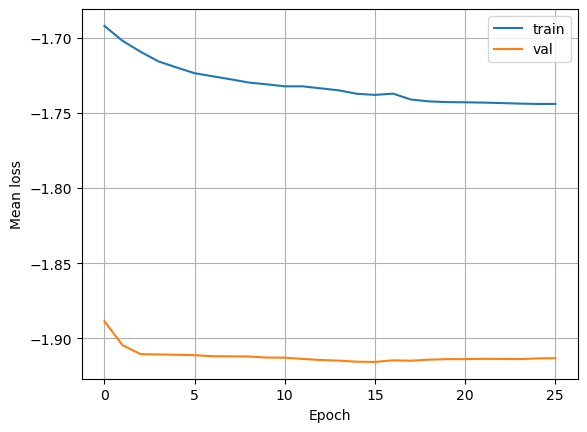

In [3715]:
import matplotlib.pyplot as plt 

# --------------------------------------------------------------------
# 2.  load later (anywhere in your code)
# --------------------------------------------------------------------
def load_goal_model(goal, in_features, C, eps, tau, device="cpu"):
    tag   = f"{goal:.3f}".replace(".", "_")
    path  = pathlib.Path("checkpoints") / f"goal_{tag}" / "best_model.pt"
    mdl   = EndToEndSVM_MVO_Sigmoid(in_features, C, eps, tau).to(device)
    mdl.load_state_dict(torch.load(path, map_location=device))
    mdl.eval()
    return mdl

# example usage  
#model = load_goal_model(return_goals[0], in_features=10, C=C_svm, eps=1e-6, tau=tau)

plt.plot(loss_hist, label="train")
plt.plot(val_hist,  label="val")
plt.xlabel("Epoch"); plt.ylabel("Mean loss")
plt.legend(); plt.grid(True); plt.show()

# In-sample

In [3716]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import cvxpy as cp

def solve_mvo(mask, mu, Sigma, return_goal):
    # mask: length-n (upper bounds, or 1 for selected assets)
    import cvxpy as cp
    n = len(mu)
    w = cp.Variable(n)
    constraints = [
        cp.sum(w) == 1,
        mu @ w >= return_goal,
        w >= 0,
        w <= mask
    ]
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), constraints)
    try:
        prob.solve(solver=cp.OSQP)
        if w.value is not None:
            return np.array(w.value).flatten()
    except Exception as e:
        pass
    return None

# 1. Pre-train SVM classifier once, on all historical training data
# svm_train_snaps = snapshots[:-23] #normally

svm_train_snaps = snapshots[:-35] #2002-2006

X_train = np.vstack([s["X_feat"] for s in svm_train_snaps])
print("X_train shape:", X_train.shape)
y_train = np.hstack([s["y"] for s in svm_train_snaps])
print("y_train shape:", y_train.shape)
svm_clf = SVC(kernel='linear', C=C_svm.item())
svm_clf.fit(X_train, y_train)

X_train shape: (5117, 10)
y_train shape: (5117,)


SVC(C=0.0062423136380732455, kernel='linear')

In [3717]:
rets_nn, vars_nn = [], []
rets_svm, vars_svm = [], []


for snap in train_snaps:
    X, y, mu, Sigma, real_ret, real_sigma = snap["X_feat"], snap["y"], snap["mu_fore"], snap["Sigma_fore"], snap["real_returns"], snap["real_sigma"]
    
    # Check if SVM has more than one class
    if len(np.unique(y)) < 2:
        continue

    # ---- NN Efficient Frontier ----
    X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))

    mu_np = np.asarray(mu)
    Sigma_np = np.asarray(Sigma)

    real_mu_np = np.asarray(real_ret)
    real_sigma_np = np.asarray(real_sigma)

    with torch.no_grad():
        w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
    w_nn = w_nn.cpu().numpy()
    ret_nn = real_mu_np @ w_nn
    var_nn = w_nn @ real_sigma_np @ w_nn

    # ---- SVM then MVO ----
    scores = svm_clf.decision_function(X)
    selected = scores > 0
    if selected.sum() < 2:
        continue  # skip this snapshot

    mu_sel = mu_np[selected]
    Sigma_sel = Sigma_np[np.ix_(selected, selected)]
    real_mu_sel = real_mu_np[selected]
    real_sigma_sel = real_sigma_np[np.ix_(selected, selected)]

    w_svm = solve_mvo(np.ones(len(mu_sel)), mu_sel, Sigma_sel, return_goals[0])
    if w_svm is None:
        continue

    ret_svm = real_mu_sel @ w_svm
    var_svm = w_svm @ real_sigma_sel @ w_svm

    rets_nn.append(ret_nn)
    vars_nn.append(var_nn)
    rets_svm.append(ret_svm)
    vars_svm.append(var_svm)

mean_ret_nn = np.mean(rets_nn)
mean_var_nn = np.mean(vars_nn)
sharpe_nn = mean_ret_nn / (np.std(rets_nn) + 1e-8)

mean_ret_svm = np.mean(rets_svm)
mean_var_svm = np.mean(vars_svm)
sharpe_svm = mean_ret_svm / (np.std(rets_svm) + 1e-8)
    

Mask mean value:  tensor(0.4737, dtype=torch.float64)
Mask mean value:  tensor(0.4992, dtype=torch.float64)
Mask mean value:  tensor(0.5139, dtype=torch.float64)
Mask mean value:  tensor(0.5054, dtype=torch.float64)
Mask mean value:  tensor(0.5340, dtype=torch.float64)
Mask mean value:  tensor(0.4666, dtype=torch.float64)
Mask mean value:  tensor(0.5152, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5321, dtype=torch.float64)
Mask mean value:  tensor(0.5707, dtype=torch.float64)
Mask mean value:  tensor(0.4795, dtype=torch.float64)
Mask mean value:  tensor(0.5006, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5021, dtype=torch.float64)

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver 

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Mask mean value:  tensor(0.5006, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5003, dtype=torch.float64)

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

Mask mean value:  tensor(0.5005, dtype=torch.float64)
Mask mean value:  tensor(0.5011, dtype=torch.float64)
Mask mean value:  tensor(0.5504, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.4083, dtype=torch.float64)

--------
qpth warning: Returning

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [3718]:
print(f"NN: Mean Return = {mean_ret_nn:.4f}, Variance = {mean_var_nn:.4f}, Sharpe = {sharpe_nn:.4f}")
print(f"SVM: Mean Return = {mean_ret_svm:.4f}, Variance = {mean_var_svm:.4f}, Sharpe = {sharpe_svm:.4f}")

NN: Mean Return = 0.0505, Variance = 0.0016, Sharpe = 1.9021
SVM: Mean Return = 0.0495, Variance = 0.0016, Sharpe = 1.7817


## Not used

In [3719]:
# import numpy as np
# import matplotlib.pyplot as plt

# n_pts = 30
# sigmas_nn, mus_nn = [], []
# sigmas_svm, mus_svm = [], []

# for snap in snapshots[:-35]:
#     X, y, mu, Sigma, real_ret, real_sigma = snap["X_feat"], snap["y"], snap["mu_fore"], snap["Sigma_fore"], snap["real_returns"], snap["real_sigma"]
    
#     # Check if SVM has more than one class
#     if len(np.unique(y)) < 2:
#         continue

#     # ---- NN Efficient Frontier ----
#     X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
    
#     mu_np = np.asarray(mu)
#     Sigma_np = np.asarray(Sigma)

#     real_mu_np = np.asarray(real_ret)
#     real_sigma_np = np.asarray(real_sigma)

#     sigma_nn, mu_nn = [], []
#     for goal in np.linspace(mu_np.min(), mu_np.max(), n_pts):
#         with torch.no_grad():
#             w, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=goal)
#         w = w.cpu().numpy()  # convert to numpy array
#         if w is not None:
#             sigma_nn.append(np.sqrt(w @ real_sigma_np @ w))
#             mu_nn.append(real_mu_np @ w)
#     if len(sigma_nn) == n_pts:
#         sigmas_nn.append(sigma_nn)
#         mus_nn.append(mu_nn)

#     # ---- SVM+MVO Efficient Frontier ----

#     scores = svm_clf.decision_function(X)
#     selected = scores > 0
#     if selected.sum() < 2:
#         continue
#     mu_sel = mu_np[selected]
#     real_mu_sel = real_mu_np[selected]

#     Sigma_sel = Sigma_np[np.ix_(selected, selected)]
#     real_sigma_np = real_sigma_np[np.ix_(selected, selected)]

#     sigma_svm, mu_svm = [], []
#     for goal in np.linspace(mu_sel.min(), mu_sel.max(), n_pts):
#         w = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, goal)
#         if w is not None:
#             sigma_svm.append(np.sqrt(w @ real_sigma_np @ w))
#             mu_svm.append(real_mu_sel @ w)
#     if len(sigma_svm) == n_pts:
#         sigmas_svm.append(sigma_svm)
#         mus_svm.append(mu_svm)

# # Convert to arrays for easier averaging
# sigmas_nn = np.array(sigmas_nn)
# mus_nn = np.array(mus_nn)
# sigmas_svm = np.array(sigmas_svm)
# mus_svm = np.array(mus_svm)

# # Compute averages
# mean_sig_nn, mean_mu_nn = sigmas_nn.mean(axis=0), mus_nn.mean(axis=0)
# mean_sig_svm, mean_mu_svm = sigmas_svm.mean(axis=0), mus_svm.mean(axis=0)

# # Plot
# plt.figure(figsize=(8,5))
# plt.plot(mean_sig_nn, mean_mu_nn, label="End-to-End NN", marker='o')
# plt.plot(mean_sig_svm, mean_mu_svm, label="SVM+MVO", marker='x')
# plt.xlabel("Portfolio Risk (Std Dev)")
# plt.ylabel("Portfolio Expected Return")
# plt.title("Average Efficient Frontiers Across All Valid Snapshots")
# plt.legend()
# plt.grid(True)
# plt.show()

# Out-of-sample

In [3720]:
def make_spd_np(M, eps=1e-6):
    M = (M + M.T) * 0.5
    I = np.eye(M.shape[0], dtype=M.dtype)
    jitter = eps
    for _ in range(10):
        try:
            np.linalg.cholesky(M)
            return M
        except np.linalg.LinAlgError:
            M = M + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

In [3721]:
# for i in range(len(test_snaps)):
#     print((test_snaps[i]['y'] == -1).sum(), (test_snaps[i]['y'] == 1).sum())

In [3722]:

results_aligned = []

for snap in val_snaps:
    X = snap["X_feat"]
    y = snap["y"]
    mu = snap["mu_fore"]
    Sigma = snap["Sigma_fore"]
    real_returns = snap["real_returns"]
    real_sigma = snap["real_sigma"]

    # If your snapshots include tickers:
    asset_names = np.asarray(snap.get("tickers", np.arange(len(X))))

    try:
        # ================== NN Portfolio ====================
        X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
        with torch.no_grad():
            w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
        w_nn = w_nn.cpu().numpy()
        mask_np = mask.cpu().numpy()

        realized_nn = real_returns[:len(w_nn)]
        port_ret_nn = (w_nn * realized_nn).sum()
        port_var_nn = w_nn @ real_sigma[:len(w_nn), :len(w_nn)] @ w_nn

        nn_selected_idx = np.where(w_nn > 1e-6)[0]
        nn_selected_names = asset_names[nn_selected_idx]

        # ================== SVM+MVO Portfolio ====================

        scores = svm_clf.decision_function(X)
        selected = scores > 0

        if selected.sum() < 2:
            print(f"Skipping {snap['date']} (SVM selected too few assets)")
            continue

        mu_sel = mu[selected]
        Sigma_sel = Sigma[np.ix_(selected, selected)]
        Sigma_sel = make_spd_np(Sigma_sel)  # Ensure SPD

        w_svm = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, return_goal=return_goals[0])
        if w_svm is None:
            print(f"Skipping {snap['date']} (SVM+MVO infeasible)")
            continue

        realized_svm = real_returns[selected]
        real_sigma_svm = real_sigma[np.ix_(selected, selected)]
        port_ret_svm = (w_svm * realized_svm).sum()
        port_var_svm = w_svm @ real_sigma_svm @ w_svm

        svm_selected_idx = np.where(w_svm > 1e-6)[0]
        svm_selected_names = asset_names[svm_selected_idx]

        # ================== Append aligned results ====================
        results_aligned.append({
            "date": snap["date"],
            "nn_return": port_ret_nn,
            "nn_variance": port_var_nn,
            "nn_selected_idx": nn_selected_idx.tolist(),
            "nn_selected_names": nn_selected_names.tolist(),
            "svm_return": port_ret_svm,
            "svm_variance": port_var_svm,
            "svm_selected_idx": svm_selected_idx.tolist(),
            "svm_selected_names": svm_selected_names.tolist(),
        })

    except Exception as e:
        print(f"Skipping {snap['date']} due to error: {e}")
        continue

# ================== Compute aligned comparisons ====================

rets_nn = [r["nn_return"] for r in results_aligned]
rets_svm = [r["svm_return"] for r in results_aligned]
vars_nn = [r["nn_variance"] for r in results_aligned]
vars_svm = [r["svm_variance"] for r in results_aligned]

print(f"\nAligned on {len(results_aligned)} snapshots.")
print(f"NN Mean Return: {np.mean(rets_nn):.6f}, Mean Variance: {np.mean(vars_nn):.6f}")
print(f"SVM+MVO Mean Return: {np.mean(rets_svm):.6f}, Mean Variance: {np.mean(vars_svm):.6f}")
print(f"NN Sharpe: {np.mean(rets_nn)/np.std(rets_nn):.6f}")
print(f"SVM+MVO Sharpe: {np.mean(rets_svm)/np.std(rets_svm):.6f}")

Mask mean value:  tensor(0.5000, dtype=torch.float64)

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

Skipping 2007-01-31 00:00:00 (SVM+MVO infeasible)
Mask mean value:  tensor(0.4995, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.4617, dtype=torch.float64)
Mask mean value:  tensor(0.4992, dtype=torch.float64)
Mask mean value:  tensor(0.5035, dtype=torch.float64)
Mask mean value:  tensor(0.5030, dtype=torch.float64)
Mask mean value:  tensor(0.6768, dtyp

In [3723]:
print("NN Out-of-Sample: Mean Return:", np.mean(rets_nn), "Mean Variance:", np.mean(vars_nn))
print("SVM+MVO Out-of-Sample: Mean Return:", np.mean(rets_svm), "Mean Variance:", np.mean(vars_svm))
print("NN Sharpe:", np.mean(rets_nn) / np.std(rets_nn))
print("SVM+MVO Sharpe:", np.mean(rets_svm) / np.std(rets_svm))

if np.mean(rets_nn) > np.mean(rets_svm):
    print("NN outperforms SVM+MVO in terms of mean return.")
else:
    print("SVM+MVO outperforms NN in terms of mean return.")
if np.mean(vars_nn) < np.mean(vars_svm):
    print("NN outperforms SVM+MVO in terms of variance.")
else:
    print("SVM+MVO outperforms NN in terms of variance.")
if np.mean(rets_nn) / np.std(rets_nn) > np.mean(rets_svm) / np.std(rets_svm):
    print("NN outperforms SVM+MVO in terms of Sharpe ratio.")
else:
    print("SVM+MVO outperforms NN in terms of Sharpe ratio.")

NN Out-of-Sample: Mean Return: 0.05332730466961048 Mean Variance: 0.0008529324895377559
SVM+MVO Out-of-Sample: Mean Return: 0.05404346848376577 Mean Variance: 0.0008313951317103251
NN Sharpe: 2.3119529978331554
SVM+MVO Sharpe: 2.027043279801196
SVM+MVO outperforms NN in terms of mean return.
SVM+MVO outperforms NN in terms of variance.
NN outperforms SVM+MVO in terms of Sharpe ratio.


In [3724]:
# use results_aligned

for r in results_aligned:
    print(f"Date: {r['date']}")
    print(f"  NN Return: {r['nn_return']:.6f}, Variance: {r['nn_variance']:.6f}, Selected Assets: {len(r['nn_selected_names'])}")
    print(f"  SVM+MVO Return: {r['svm_return']:.6f}, Variance: {r['svm_variance']:.6f}, Selected Assets: {len(r['svm_selected_names'])}")

Date: 2007-02-28 00:00:00
  NN Return: 0.043380, Variance: 0.001954, Selected Assets: 2
  SVM+MVO Return: 0.039650, Variance: 0.001689, Selected Assets: 3
Date: 2007-03-31 00:00:00
  NN Return: 0.119646, Variance: 0.002832, Selected Assets: 3
  SVM+MVO Return: 0.131374, Variance: 0.002880, Selected Assets: 4
Date: 2007-04-30 00:00:00
  NN Return: 0.048305, Variance: 0.000438, Selected Assets: 34
  SVM+MVO Return: 0.048305, Variance: 0.000438, Selected Assets: 34
Date: 2007-05-31 00:00:00
  NN Return: 0.033212, Variance: 0.000409, Selected Assets: 16
  SVM+MVO Return: 0.033212, Variance: 0.000409, Selected Assets: 16
Date: 2007-06-30 00:00:00
  NN Return: 0.050063, Variance: 0.000468, Selected Assets: 8
  SVM+MVO Return: 0.050063, Variance: 0.000468, Selected Assets: 8
Date: 2007-07-31 00:00:00
  NN Return: 0.051820, Variance: 0.000394, Selected Assets: 26
  SVM+MVO Return: 0.051820, Variance: 0.000394, Selected Assets: 26
Date: 2007-08-31 00:00:00
  NN Return: 0.058333, Variance: 0.000

# Test

In [3725]:
results_aligned = []
for snap in test_snaps:
    X = snap["X_feat"]
    y = snap["y"]
    mu = snap["mu_fore"]
    Sigma = snap["Sigma_fore"]
    real_returns = snap["real_returns"]
    real_sigma = snap["real_sigma"]

    # If your snapshots include tickers:
    asset_names = np.asarray(snap.get("tickers", np.arange(len(X))))

    try:
        # ================== NN Portfolio ====================
        X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
        with torch.no_grad():
            w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
        w_nn = w_nn.cpu().numpy()
        mask_np = mask.cpu().numpy()

        realized_nn = real_returns[:len(w_nn)]
        port_ret_nn = (w_nn * realized_nn).sum()
        port_var_nn = w_nn @ real_sigma[:len(w_nn), :len(w_nn)] @ w_nn

        nn_selected_idx = np.where(w_nn > 1e-6)[0]
        nn_selected_names = asset_names[nn_selected_idx]

        # ================== SVM+MVO Portfolio ====================
        scores = svm_clf.decision_function(X)
        selected = scores > 0

        if selected.sum() < 2:
            print(f"Skipping {snap['date']} (SVM selected too few assets)")
            continue

        mu_sel = mu[selected]
        Sigma_sel = Sigma[np.ix_(selected, selected)]
        Sigma_sel = make_spd_np(Sigma_sel)  # Ensure SPD

        w_svm = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, return_goal=return_goals[0])
        if w_svm is None:
            print(f"Skipping {snap['date']} (SVM+MVO infeasible)")
            continue

        realized_svm = real_returns[selected]
        real_sigma_svm = real_sigma[np.ix_(selected, selected)]
        port_ret_svm = (w_svm * realized_svm).sum()
        port_var_svm = w_svm @ real_sigma_svm @ w_svm

        svm_selected_idx = np.where(w_svm > 1e-6)[0]
        svm_selected_names = asset_names[svm_selected_idx]

        # ================== Append aligned results ====================
        results_aligned.append({
            "date": snap["date"],
            "nn_return": port_ret_nn,
            "nn_variance": port_var_nn,
            "nn_selected_idx": nn_selected_idx.tolist(),
            "nn_selected_names": nn_selected_names.tolist(),
            "svm_return": port_ret_svm,
            "svm_variance": port_var_svm,
            "svm_selected_idx": svm_selected_idx.tolist(),
            "svm_selected_names": svm_selected_names.tolist(),
        })

    except Exception as e:
        print(f"Skipping {snap['date']} due to error: {e}")
        continue

# ================== Compute aligned comparisons ====================

rets_nn = [r["nn_return"] for r in results_aligned]
rets_svm = [r["svm_return"] for r in results_aligned]
vars_nn = [r["nn_variance"] for r in results_aligned]
vars_svm = [r["svm_variance"] for r in results_aligned]

print(f"\nAligned on {len(results_aligned)} snapshots.")
print(f"NN Mean Return: {np.mean(rets_nn):.6f}, Mean Variance: {np.mean(vars_nn):.6f}")
print(f"SVM+MVO Mean Return: {np.mean(rets_svm):.6f}, Mean Variance: {np.mean(vars_svm):.6f}")
print(f"NN Sharpe: {np.mean(rets_nn)/np.std(rets_nn):.6f}")
print(f"SVM+MVO Sharpe: {np.mean(rets_svm)/np.std(rets_svm):.6f}")

Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5009, dtype=torch.float64)

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

Mask mean value:  tensor(0.5000, dtype=torch.float64)

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advance

In [3726]:
print("NN Out-of-Sample: Mean Return:", np.mean(rets_nn), "Mean Variance:", np.mean(vars_nn))
print("SVM+MVO Out-of-Sample: Mean Return:", np.mean(rets_svm), "Mean Variance:", np.mean(vars_svm))
print("NN Sharpe:", np.mean(rets_nn) / np.std(rets_nn))
print("SVM+MVO Sharpe:", np.mean(rets_svm) / np.std(rets_svm))

if np.mean(rets_nn) > np.mean(rets_svm):
    print("NN outperforms SVM+MVO in terms of mean return.")
else:
    print("SVM+MVO outperforms NN in terms of mean return.")
if np.mean(vars_nn) < np.mean(vars_svm):
    print("NN outperforms SVM+MVO in terms of variance.")
else:
    print("SVM+MVO outperforms NN in terms of variance.")
if np.mean(rets_nn) / np.std(rets_nn) > np.mean(rets_svm) / np.std(rets_svm):
    print("NN outperforms SVM+MVO in terms of Sharpe ratio.")
else:
    print("SVM+MVO outperforms NN in terms of Sharpe ratio.")

NN Out-of-Sample: Mean Return: 0.07271788850522551 Mean Variance: 0.0042400055129443535
SVM+MVO Out-of-Sample: Mean Return: 0.08133119045912733 Mean Variance: 0.00501691643861084
NN Sharpe: 1.3367174565306872
SVM+MVO Sharpe: 0.939732217216737
SVM+MVO outperforms NN in terms of mean return.
NN outperforms SVM+MVO in terms of variance.
NN outperforms SVM+MVO in terms of Sharpe ratio.


In [3727]:
# use results_aligned

for r in results_aligned:
    print(f"Date: {r['date']}")
    print(f"  NN Return: {r['nn_return']:.6f}, Variance: {r['nn_variance']:.6f}, Selected Assets: {len(r['nn_selected_names'])}")
    print(f"  SVM+MVO Return: {r['svm_return']:.6f}, Variance: {r['svm_variance']:.6f}, Selected Assets: {len(r['svm_selected_names'])}")

Date: 2008-01-31 00:00:00
  NN Return: 0.071401, Variance: 0.000942, Selected Assets: 8
  SVM+MVO Return: 0.071401, Variance: 0.000942, Selected Assets: 8
Date: 2008-02-29 00:00:00
  NN Return: 0.091199, Variance: 0.006527, Selected Assets: 3
  SVM+MVO Return: 0.090351, Variance: 0.007525, Selected Assets: 2
Date: 2008-03-31 00:00:00
  NN Return: 0.241701, Variance: 0.009590, Selected Assets: 3
  SVM+MVO Return: 0.426736, Variance: 0.025166, Selected Assets: 2
Date: 2008-04-30 00:00:00
  NN Return: 0.084023, Variance: 0.001423, Selected Assets: 16
  SVM+MVO Return: 0.081390, Variance: 0.001280, Selected Assets: 18
Date: 2008-06-30 00:00:00
  NN Return: 0.075086, Variance: 0.001119, Selected Assets: 19
  SVM+MVO Return: 0.075086, Variance: 0.001119, Selected Assets: 19
Date: 2008-07-31 00:00:00
  NN Return: 0.062970, Variance: 0.001179, Selected Assets: 31
  SVM+MVO Return: 0.062970, Variance: 0.001179, Selected Assets: 31
Date: 2008-08-31 00:00:00
  NN Return: 0.062770, Variance: 0.011

## Test 2009

In [3588]:
results_aligned = []
test_snaps = snapshots[-11:]
for snap in test_snaps:
    X = snap["X_feat"]
    y = snap["y"]
    mu = snap["mu_fore"]
    Sigma = snap["Sigma_fore"]
    real_returns = snap["real_returns"]
    real_sigma = snap["real_sigma"]

    # If your snapshots include tickers:
    asset_names = np.asarray(snap.get("tickers", np.arange(len(X))))

    try:
        # ================== NN Portfolio ====================
        X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
        with torch.no_grad():
            w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
        w_nn = w_nn.cpu().numpy()
        mask_np = mask.cpu().numpy()
        realized_nn = real_returns[:len(w_nn)]
        port_ret_nn = (w_nn * realized_nn).sum()
        port_var_nn = w_nn @ real_sigma[:len(w_nn), :len(w_nn)] @ w_nn

        nn_selected_idx = np.where(w_nn > 1e-6)[0]
        nn_selected_names = asset_names[nn_selected_idx]

        # ================== SVM+MVO Portfolio ====================

        scores = svm_clf.decision_function(X)
        selected = scores > 0

        if selected.sum() < 2:
            print(f"Skipping {snap['date']} (SVM selected too few assets)")
            continue

        mu_sel = mu[selected]
        Sigma_sel = Sigma[np.ix_(selected, selected)]
        Sigma_sel = make_spd_np(Sigma_sel)  # Ensure SPD

        w_svm = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, return_goal=return_goals[0])
        if w_svm is None:
            print(f"Skipping {snap['date']} (SVM+MVO infeasible)")
            continue

        realized_svm = real_returns[selected]
        real_sigma_svm = real_sigma[np.ix_(selected, selected)]
        port_ret_svm = (w_svm * realized_svm).sum()
        port_var_svm = w_svm @ real_sigma_svm @ w_svm

        svm_selected_idx = np.where(w_svm > 1e-6)[0]
        svm_selected_names = asset_names[svm_selected_idx]

        # ================== Append aligned results ====================
        results_aligned.append({
            "date": snap["date"],
            "nn_return": port_ret_nn,
            "nn_variance": port_var_nn,
            "nn_selected_idx": nn_selected_idx.tolist(),
            "nn_selected_names": nn_selected_names.tolist(),
            "svm_return": port_ret_svm,
            "svm_variance": port_var_svm,
            "svm_selected_idx": svm_selected_idx.tolist(),
            "svm_selected_names": svm_selected_names.tolist(),
        })

    except Exception as e:
        print(f"Skipping {snap['date']} due to error: {e}")
        continue

# ================== Compute aligned comparisons ====================

rets_nn = [r["nn_return"] for r in results_aligned]
rets_svm = [r["svm_return"] for r in results_aligned]
vars_nn = [r["nn_variance"] for r in results_aligned]
vars_svm = [r["svm_variance"] for r in results_aligned]

print(f"\nAligned on {len(results_aligned)} snapshots.")
print(f"NN Mean Return: {np.mean(rets_nn):.6f}, Mean Variance: {np.mean(vars_nn):.6f}")
print(f"SVM+MVO Mean Return: {np.mean(rets_svm):.6f}, Mean Variance: {np.mean(vars_svm):.6f}")
print(f"NN Sharpe: {np.mean(rets_nn)/np.std(rets_nn):.6f}")
print(f"SVM+MVO Sharpe: {np.mean(rets_svm)/np.std(rets_svm):.6f}")

Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.4309, dtype=torch.float64)
Mask mean value:  tensor(0.5690, dtype=torch.float64)
Mask mean value:  tensor(0.6043, dtype=torch.float64)
Mask mean value:  tensor(0.4262, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.6872, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)
Mask mean value:  tensor(0.8883, dtype=torch.float64)
Mask mean value:  tensor(0.5000, dtype=torch.float64)

Aligned on 11 snapshots.
NN Mean Return: 0.069093, Mean Variance: 0.004291
SVM+MVO Mean Return: 0.063955, Mean Variance: 0.003463
NN Sharpe: 1.718602
SVM+MVO Sharpe: 1.868731


In [3589]:
print("NN Out-of-Sample: Mean Return:", np.mean(rets_nn), "Mean Variance:", np.mean(vars_nn))
print("SVM+MVO Out-of-Sample: Mean Return:", np.mean(rets_svm), "Mean Variance:", np.mean(vars_svm))
print("NN Sharpe:", np.mean(rets_nn) / np.std(rets_nn))
print("SVM+MVO Sharpe:", np.mean(rets_svm) / np.std(rets_svm))

if np.mean(rets_nn) > np.mean(rets_svm):
    print("NN outperforms SVM+MVO in terms of mean return.")
else:
    print("SVM+MVO outperforms NN in terms of mean return.")
if np.mean(vars_nn) < np.mean(vars_svm):
    print("NN outperforms SVM+MVO in terms of variance.")
else:
    print("SVM+MVO outperforms NN in terms of variance.")
if np.mean(rets_nn) / np.std(rets_nn) > np.mean(rets_svm) / np.std(rets_svm):
    print("NN outperforms SVM+MVO in terms of Sharpe ratio.")
else:
    print("SVM+MVO outperforms NN in terms of Sharpe ratio.")

NN Out-of-Sample: Mean Return: 0.06909345240060878 Mean Variance: 0.004290982631939499
SVM+MVO Out-of-Sample: Mean Return: 0.06395496125838941 Mean Variance: 0.003462870008632452
NN Sharpe: 1.718602003738915
SVM+MVO Sharpe: 1.8687308230401225
NN outperforms SVM+MVO in terms of mean return.
SVM+MVO outperforms NN in terms of variance.
SVM+MVO outperforms NN in terms of Sharpe ratio.


In [3590]:
# use results_aligned

for r in results_aligned:
    print(f"Date: {r['date']}")
    print(f"  NN Return: {r['nn_return']:.6f}, Variance: {r['nn_variance']:.6f}, Selected Assets: {len(r['nn_selected_names'])}")
    print(f"  SVM+MVO Return: {r['svm_return']:.6f}, Variance: {r['svm_variance']:.6f}, Selected Assets: {len(r['svm_selected_names'])}")

Date: 2009-01-31 00:00:00
  NN Return: 0.011111, Variance: 0.003063, Selected Assets: 14
  SVM+MVO Return: 0.011111, Variance: 0.003063, Selected Assets: 14
Date: 2009-02-28 00:00:00
  NN Return: 0.142369, Variance: 0.004580, Selected Assets: 13
  SVM+MVO Return: 0.142369, Variance: 0.004580, Selected Assets: 13
Date: 2009-03-31 00:00:00
  NN Return: 0.129705, Variance: 0.012428, Selected Assets: 24
  SVM+MVO Return: 0.068872, Variance: 0.003975, Selected Assets: 48
Date: 2009-04-30 00:00:00
  NN Return: 0.097909, Variance: 0.004113, Selected Assets: 16
  SVM+MVO Return: 0.091120, Variance: 0.003872, Selected Assets: 19
Date: 2009-05-31 00:00:00
  NN Return: 0.052022, Variance: 0.003913, Selected Assets: 52
  SVM+MVO Return: 0.058386, Variance: 0.003558, Selected Assets: 45
Date: 2009-06-30 00:00:00
  NN Return: 0.068838, Variance: 0.003512, Selected Assets: 23
  SVM+MVO Return: 0.071330, Variance: 0.004187, Selected Assets: 29
Date: 2009-07-31 00:00:00
  NN Return: 0.031937, Variance:

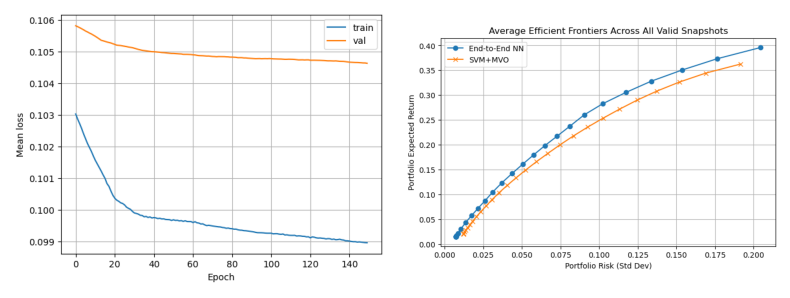

In [3591]:
import matplotlib.pyplot as plt

# List of your PNG files
png_files = ['plots/9curve.png', 'plots/9eff.png']  # replace with your file names

n = len(png_files)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 24))

# Flatten axes for easy iteration (handles 1D/2D arrays)
axes = axes.flatten()

for ax, img_file in zip(axes, png_files):
    img = plt.imread(img_file)
    ax.imshow(img)
    ax.axis('off')  # Hide axes ticks

# Hide unused subplots, if any
for ax in axes[len(png_files):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig('plots/9combined.png', bbox_inches='tight', dpi=300)
plt.show()
# save the figure
